# Case Study: Automatic Ticket Classification

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

nlp = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-18 06:36:36.319723: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Opening JSON file
jsonFile = open("/drive/My Drive/Colab Notebooks/AutomaticTicketClassification/complaints-2021-05-14_08_16.json", "r")
  
# returns JSON object as  
# a dictionary 
data = json.load(jsonFile)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
df.shape

(78313, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
                   '_source.zip_code':'zip_code',
                   '_source.complaint_id':'complaint_id',
                   '_source.issue':'issue',
                   '_source.date_received':'date_received',
                   '_source.state':'state',
                   '_source.consumer_disputed':'consumer_disputed',
                   '_source.product':'product',
                   '_source.company_response':'company_response',
                   '_source.company':'company',
                   '_source.submitted_via':'submitted_via',
                   '_source.date_sent_to_company':'date_sent_to_company',
                   '_source.company_public_response':'company_public_response',
                   '_source.sub_product':'sub_product',
                   '_source.timely':'timely',
                   '_source.complaint_what_happened':'complaint_what_happened',
                   '_source.sub_issue':'sub_issue',
                   '_source.consumer_consent_provided':'consumer_consent_provided'},
          inplace=True)

In [ ]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened']==''] = np.nan

In [ ]:
df.isna().sum()

_index                       57241
_type                        57241
_id                          57241
_score                       57241
tags                         74497
zip_code                     61886
complaint_id                 57241
issue                        57241
date_received                57241
state                        57384
consumer_disputed            57241
product                      57241
company_response             57241
company                      57241
submitted_via                57241
date_sent_to_company         57241
company_public_response      78311
sub_product                  59350
timely                       57241
complaint_what_happened      57241
sub_issue                    65417
consumer_consent_provided    57241
dtype: int64

In [ ]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])

In [ ]:
df.isna().sum()

_index                           0
_type                            0
_id                              0
_score                           0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

In [ ]:
df.shape

(21072, 22)

In [ ]:
df.reset_index(inplace = True, drop = True)

In [ ]:
df.shape

(21072, 22)

In [ ]:
df.head()

,_index,_type,_id,_score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  #1. convert to lower
  text = text.lower()
  #2. remove text in sq. bracket
  text=re.sub(r'\[.*?\]', '', text)
  #3. remove punctuation
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
  #4. remove words with numbers
  text = re.sub(r'\w*\d\w*', '', text)
  
  return text

In [ ]:
# Test above method
sample = df.complaint_what_happened.sample().values[0]
print(sample)
print("---------------------------------")
cleanSample = clean_text(sample)
print(cleanSample)

I tried to sell used furniture on XXXX, and someone contacted me that he is interested in the furniture, he paid me an e-check ( {$640.00} XXXX through e-mail and ask me to deposit on the mobile phone, the check is cleared the following business day, and the buyer wants me to buy a visa gift card ( {$350.00} with {$5.00} activation fee ) to pay for the mover, the money has already covered in the e-check the buyer sent to me in the first, I bought the gift card and contact the mover to schedule the pickup, the mover process the card and said they will be the pick-up location in an hour, after two hours the person who sent me the check said he wants to cancel the deal and ask me to send part of the money-back ( {$250.00} XXXX through XXXX pays to his brother-in-law 's account, and cancel the deal. I paid the amount to cancel the deal, and the third business day, my bank notified me that they can not locate the account and return the money back, and charged me for NSF {$12.00}. In total {

In [ ]:
# Write your function to Lemmatize the texts
def lemmatize_text(text):
  sentence = []
  doc = nlp(text)
  for word in doc:
    sentence.append(word.lemma_)

  return " ".join(sentence)

In [ ]:
# Test above method
print(cleanSample)
print("---------------------------------")
lemmatizedText = lemmatize_text(cleanSample)
print(lemmatizedText)

i tried to sell used furniture on xxxx and someone contacted me that he is interested in the furniture he paid me an echeck   xxxx through email and ask me to deposit on the mobile phone the check is cleared the following business day and the buyer wants me to buy a visa gift card   with  activation fee  to pay for the mover the money has already covered in the echeck the buyer sent to me in the first i bought the gift card and contact the mover to schedule the pickup the mover process the card and said they will be the pickup location in an hour after two hours the person who sent me the check said he wants to cancel the deal and ask me to send part of the moneyback   xxxx through xxxx pays to his brotherinlaw s account and cancel the deal i paid the amount to cancel the deal and the third business day my bank notified me that they can not locate the account and return the money back and charged me for nsf  in total  lost 

i doublechecked with my bank about the validity of the check 

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()

In [ ]:
df_clean['complaint'] = df['complaint_what_happened'].progress_apply(clean_text)

100%|██████████| 21072/21072 [00:02<00:00, 9037.97it/s]


In [ ]:
df_clean['lemmatized_complaint'] = df_clean['complaint'].progress_apply(lemmatize_text)

100%|██████████| 21072/21072 [12:59<00:00, 27.04it/s]


In [ ]:
df_clean.head()

,complaint,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [ ]:
df_clean.shape

(21072, 2)

In [ ]:
#Write your function to extract the POS tags
from nltk import word_tokenize, pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_pos_tag(text):
  return pos_tag(word_tokenize(text))

def get_NN(text):
  NN = []
  wordsWithTags = get_pos_tag(text)
  for word, tag in wordsWithTags:
    if (tag == 'NN'):
      NN.append(word)
  
  return " ".join(NN)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Test above method
print(lemmatizedText)
print("---------------------------------")
print(get_pos_tag(lemmatizedText))
print("---------------------------------")
lemmatizedTextPosRemoved = get_NN(lemmatizedText)
print(lemmatizedTextPosRemoved)

I try to sell used furniture on xxxx and someone contact I that he be interested in the furniture he pay I an echeck    xxxx through email and ask I to deposit on the mobile phone the check be clear the follow business day and the buyer want I to buy a visa gift card    with   activation fee   to pay for the mover the money have already cover in the echeck the buyer send to I in the first I buy the gift card and contact the mover to schedule the pickup the mover process the card and say they will be the pickup location in an hour after two hour the person who send I the check say he want to cancel the deal and ask I to send part of the moneyback    xxxx through xxxx pay to his brotherinlaw s account and cancel the deal I pay the amount to cancel the deal and the third business day my bank notify I that they can not locate the account and return the money back and charge I for nsf   in total   lose 

 I doublechecke with my bank about the validity of the check and they confirm the check

In [ ]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['lemmatized_complaint'].progress_apply(get_NN)

100%|██████████| 21072/21072 [03:52<00:00, 90.81it/s]


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


In [ ]:
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




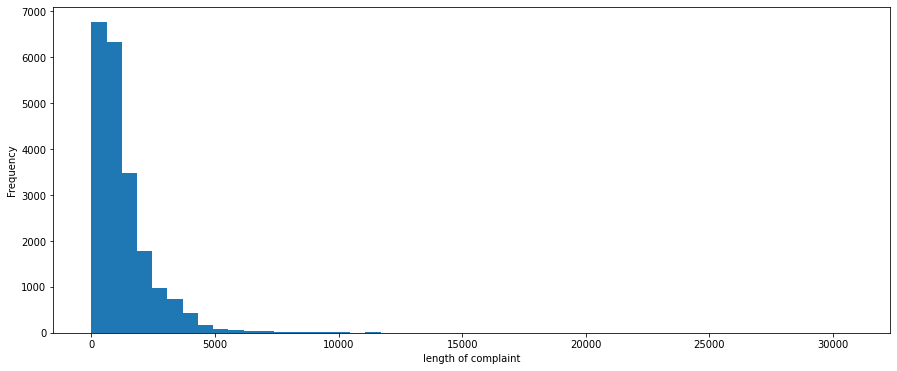

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.xlabel("length of complaint")
df_clean['complaint'].str.len().plot(
    kind='hist', 
    bins=50,
    figsize=(15,6)
)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


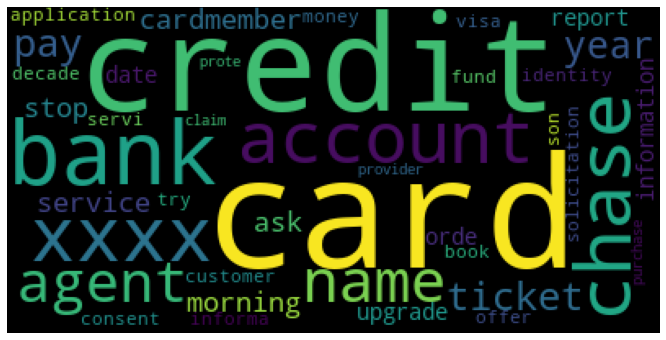

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
wordcloud = WordCloud(max_words=40).generate(str(df_clean.complaint_POS_removed))
print(wordcloud)
plt.figure(figsize=(15,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# Top 40 words
print(list(wordcloud.words_.keys())[:40])

['card', 'credit', 'bank', 'xxxx', 'chase', 'account', 'name', 'agent', 'ticket', 'pay', 'year', 'morning', 'stop', 'cardmember', 'service', 'ask', 'upgrade', 'date', 'information', 'orde', 'report', 'application', 'identity', 'consent', 'servi', 'try', 'book', 'offer', 'informa', 'son', 'fund', 'money', 'customer', 'decade', 'solicitation', 'visa', 'provider', 'claim', 'purchase', 'prote']


In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [ ]:
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

def get_top_n_words(corpus, n=None):
  vec=CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0)
  words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True )
  return words_freq[:n]

common_words = get_top_n_words(df_clean['Complaint_clean'].values.astype('U'),30)
df_unigram = pd.DataFrame(common_words,columns=['unigram', 'count'])

fig = go.Figure([go.Bar(x=df_unigram['unigram'], y=df_unigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 unigrams in the cleaned complaint text')) 
fig.show()

In [ ]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47492
1,chase,46693
2,xxxx,36531
3,credit,34132
4,card,29279
5,bank,28408
6,payment,21167
7,time,16033
8,charge,14991
9,day,12966


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec=CountVectorizer(stop_words='english',ngram_range=(2, 2)).fit(corpus)
    bag_of_words=vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True )
    return words_freq[:n]

common_words = get_top_n_bigram(df_clean['Complaint_clean'].values.astype('U'),30)
df_bigram = pd.DataFrame(common_words,columns=['bigram', 'count'])

fig = go.Figure([go.Bar(x=df_bigram['bigram'], y=df_bigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 bigram in the cleaned complaint text')) 
fig.show()

In [ ]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12779
1,credit report,4003
2,xxxx xxxx,3931
3,customer service,3079
4,chase credit,2967
5,chase bank,2944
6,bank account,2778
7,chase account,2619
8,account chase,2595
9,account account,2414


In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus,n=None):
  vec=CountVectorizer(stop_words='english',ngram_range=(3, 3)).fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0)
  words_freq=[(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq, key= lambda x: x[1], reverse=True)
  return words_freq[:n]

common_words=get_top_n_trigram(df_clean['Complaint_clean'].values.astype('U'), 30)
df_trigram=pd.DataFrame(common_words, columns=['trigram', 'count'])

fig=go.Figure([go.Bar(x=df_trigram['trigram'], y=df_trigram['count'])])
fig.update_layout(title=go.layout.Title(text='Top 30 trigram in the cleaned complaint text')) 
fig.show()

In [ ]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,634
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,401
9,card credit card,388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


In [ ]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [108]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [109]:
vect = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [110]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean['Complaint_clean'])

pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,aarp,ab,abandon,abandonment,abatement,abbreviation,abd,abide,ability,...,yrs,ys,ytd,zelle,zero,zip,zipcode,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [112]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [113]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40, max_iter = 500)
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [114]:
#Print the Top 15 words for each of the topics
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number,business,transaction,checking,claim,transfer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,purchase,claim,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [115]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
df_topics = pd.DataFrame(W, columns=[i for i in range(num_topics)])

df_topics['Topic'] = df_topics.apply(lambda x: x.idxmax(), axis=1)
df_topics.head(5)

,0,1,2,3,4,Topic
0,0.022737,0.012929,0.006605,0.007206,0.021820,0
1,0.009141,0.014690,0.002169,0.011733,0.006057,1
2,0.000000,0.061309,0.000000,0.000000,0.000000,1
3,0.018620,0.063774,0.000025,0.004634,0.020461,1
4,0.071178,0.000000,0.000000,0.001770,0.007110,0


In [116]:
df_topics.shape

(21072, 6)

In [117]:
#Assign the best topic to each of the complaint in Topic Column
df_clean['Topic'] = df_topics['Topic']
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [118]:
df_clean.shape

(21072, 5)

In [119]:
#Print the first 5 Complaint for each of the Topics
df_clean_grouped = df_clean.groupby('Topic').head(5)
df_clean_grouped.sort_values('Topic')

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
5,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [120]:
print("Topic 0 ----------")
print(df_clean[df_clean['Topic'] == 0].values[0][0])
print("Topic 1 ----------")
print(df_clean[df_clean['Topic'] == 1].values[0][0])
print("Topic 2 ----------")
print(df_clean[df_clean['Topic'] == 2].values[0][0])
print("Topic 3 ----------")
print(df_clean[df_clean['Topic'] == 3].values[0][0])
print("Topic 4 ----------")
print(df_clean[df_clean['Topic'] == 4].values[0][0])

Topic 0 ----------
good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help
Topic 1 ----------
i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
Topic 2 ----------
during the summer months i experience a decline income due to my employment therefore i request a one month payment extension wit

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [121]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Banking Services', 1:'Credit Card related Services', 
               2:'Others', 3:'Fraud and Dispute', 4:'Mortgage and Loan Services'}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [122]:
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Banking Services
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit Card related Services
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit Card related Services
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit Card related Services
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Banking Services


In [123]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [124]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Banking Services":0,"Credit Card related Services":1,"Others":2,"Fraud and Dispute":3,"Mortgage and Loan Services":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [125]:
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [126]:
df_clean.shape

(21072, 5)

In [127]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint","Topic"]]

In [128]:
training_data.head()

,complaint,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,1
3,on while trying to book a xxxx xxxx ticket ...,1
4,my grand son give me check for i deposit it i...,0


In [129]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [130]:
from sklearn.feature_extraction.text import CountVectorizer

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint'])

In [131]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [132]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train_tfidf,training_data.Topic,test_size=0.25,random_state=40)

In [133]:
print('X_Train',X_train.shape)
print('y_train',y_train.shape)
print('X_Test',X_test.shape)
print('y_test',y_test.shape)

X_Train (15804, 33599)
y_train (15804,)
X_Test (5268, 33599)
y_test (5268,)


In [134]:
# Creating a dataframe to store all models result
result_df = pd.DataFrame({"Original Value":y_test})

## Model 1 - Logistic Regression

In [135]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=40)
lr.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(multi_class='multinomial', random_state=40)

In [136]:
y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC on train : {accuracy_score(y_train,y_pred_train)}')
print(F'ACC on test : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC on train : 0.971336370539104
ACC on test : 0.9246393318147305
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1315
           1       0.93      0.93      0.93      1239
           2       0.95      0.86      0.90       576
           3       0.89      0.91      0.90      1192
           4       0.95      0.93      0.94       946

    accuracy                           0.92      5268
   macro avg       0.93      0.92      0.92      5268
weighted avg       0.93      0.92      0.92      5268



In [139]:
result_df['Logistic_reg'] = y_pred
result_df.head(5)

,Original Value,Logistic_reg
3314,0,0
8270,3,3
13370,2,2
13270,0,0
20108,1,1


# Model 2 - Decision Tree

In [140]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=40)
params = {
    'max_depth':[2,5,10],
    'min_samples_leaf':[5,10,20],
    'min_samples_split':[5,10,20]
}
grid_search = GridSearchCV(estimator=dt,
            param_grid=params,
            cv=3,
            n_jobs=-1,verbose=10,
            scoring="accuracy")

grid_result = grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [141]:
grid_result.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=5,
                       random_state=40)

In [142]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=5,
                       random_state=40).fit(X_train,y_train)

In [143]:
y_pred_train = dt.predict(X_train)
y_pred = dt.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC on train : {accuracy_score(y_train,y_pred_train)}')
print(F'ACC on test : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC on train : 0.7944824095165781
ACC on test : 0.7708807896735004
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1315
           1       0.80      0.83      0.81      1239
           2       0.79      0.73      0.76       576
           3       0.80      0.63      0.70      1192
           4       0.66      0.88      0.76       946

    accuracy                           0.77      5268
   macro avg       0.77      0.77      0.77      5268
weighted avg       0.78      0.77      0.77      5268



In [144]:
result_df['Decision_Tree'] = y_pred
result_df.head()

,Original Value,Logistic_reg,Decision_Tree
3314,0,0,0
8270,3,3,4
13370,2,2,2
13270,0,0,0
20108,1,1,1


# Model 3 - Random Forest

In [145]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 50, max_depth=10, random_state=40).fit(X_train,y_train)

In [146]:
y_pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)
clf_report = classification_report(y_test,y_pred)
print(F'ACC on train : {accuracy_score(y_train,y_pred_train)}')
print(F'ACC on test : {accuracy_score(y_test,y_pred)}')
print(clf_report)

ACC on train : 0.7528473804100227
ACC on test : 0.7057706909643129
              precision    recall  f1-score   support

           0       0.68      0.87      0.76      1315
           1       0.61      0.85      0.72      1239
           2       0.95      0.06      0.12       576
           3       0.78      0.72      0.75      1192
           4       0.86      0.66      0.75       946

    accuracy                           0.71      5268
   macro avg       0.78      0.63      0.62      5268
weighted avg       0.75      0.71      0.67      5268



In [147]:
result_df['Random Forest'] = y_pred
result_df.head()

,Original Value,Logistic_reg,Decision_Tree,Random Forest
3314,0,0,0,0
8270,3,3,4,3
13370,2,2,2,3
13270,0,0,0,0
20108,1,1,1,1


## Out of above 3 models, Logistic Regression has given best accuracy score on train and test dataset

ACC on train : 0.971336370539104

ACC on test : 0.9246393318147305

---